In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from datetime import datetime
import re

In [2]:
def process_single_gauge(gauge_id, input_folder, output_folder, plot=True):
    """
    Process a single gauge streamflow file and convert it to CSV format.
    
    Parameters:
    gauge_id (str or int): The gauge ID to process
    input_folder (str): Path to folder containing DFL files
    output_folder (str): Path to folder where CSV files will be saved
    plot (bool): Whether to create a time series plot
    
    Returns:
    pandas.DataFrame: Processed streamflow data
    """
    
    # Ensure gauge_id is string
    gauge_id = str(gauge_id)
    
    # Define file paths
    input_file = os.path.join(input_folder, f"DFL_{gauge_id}.txt")
    output_file = os.path.join(output_folder, f"streamflow_{gauge_id}.csv")
    
    # Check if input file exists
    if not os.path.exists(input_file):
        print(f"Warning: File {input_file} does not exist!")
        return None
    
    # Create output directory if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)
    
    try:
        # Read the file
        with open(input_file, 'r') as f:
            lines = f.readlines()
        
        # Find where the data starts (after the years list)
        data_start_idx = 0
        for i, line in enumerate(lines):
            # Look for lines that start with date format (DD/MMM/YYYY)
            if re.match(r'\d{2}/\w{3}/\d{4}', line.strip()):
                data_start_idx = i
                break
        
        # Extract data lines
        data_lines = [line.strip() for line in lines[data_start_idx:] if line.strip()]
        
        # Parse data
        dates = []
        flows = []
        
        for line in data_lines:
            if ',' in line:
                date_str, flow_str = line.split(',')
                try:
                    # Parse date
                    date = pd.to_datetime(date_str, format='%d/%b/%Y')
                    dates.append(date)
                    
                    # Parse flow value
                    try:
                        flow = float(flow_str)
                        flows.append(flow)
                    except ValueError:
                        # ✅ UPDATED: If flow value can't be parsed, treat as NaN
                        flows.append(np.nan)
                        
                except ValueError:
                    # If date can't be parsed, skip this line
                    continue
        
        # Create DataFrame
        df = pd.DataFrame({
            'date': dates,
            'Q_obs': flows
        })
        
        # Sort by date
        df = df.sort_values('date').reset_index(drop=True)
        
        # Create complete date range and fill missing values
        if len(df) > 0:
            date_range = pd.date_range(start=df['date'].min(), 
                                     end=df['date'].max(), 
                                     freq='D')
            
            # ✅ UPDATED: Reindex to include all dates, keeping NaN for missing values
            df_complete = df.set_index('date').reindex(date_range).reset_index()
            df_complete.columns = ['date', 'Q_obs']
        else:
            df_complete = df
        
        # Save to CSV
        df_complete.to_csv(output_file, index=False)
        print(f"Successfully processed gauge {gauge_id}. Output saved to: {output_file}")
        
        # Create plot if requested
        if plot and len(df_complete) > 0:
            plt.figure(figsize=(12, 6))
            
            # ✅ UPDATED: Only plot non-NaN values for better visualization
            plot_data = df_complete.dropna(subset=['Q_obs']).copy()
            
            if len(plot_data) > 0:
                plt.plot(plot_data['date'], plot_data['Q_obs'], 'b-', linewidth=0.8)
                plt.title(f'Streamflow Time Series - Gauge {gauge_id}')
                plt.xlabel('Date')
                plt.ylabel('Discharge (m³/s)')
                plt.grid(True, alpha=0.3)
                plt.xticks(rotation=45)
                plt.tight_layout()
                
                # Save plot
                plot_file = os.path.join(output_folder, f"streamflow_{gauge_id}_plot.png")
                plt.savefig(plot_file, dpi=300, bbox_inches='tight')
                plt.show()
                
                print(f"Plot saved to: {plot_file}")
            else:
                print(f"No valid data to plot for gauge {gauge_id}")
        
        return df_complete
        
    except Exception as e:
        print(f"Error processing gauge {gauge_id}: {str(e)}")
        return None

In [3]:
def get_all_gauge_ids(input_folder):
    """
    Identify all gauge IDs in the input folder.
    
    Parameters:
    input_folder (str): Path to folder containing DFL files
    
    Returns:
    list: List of gauge IDs found in the folder
    """
    
    # Find all DFL files
    dfl_files = glob.glob(os.path.join(input_folder, "DFL_*.txt"))
    
    # Extract gauge IDs
    gauge_ids = []
    for file_path in dfl_files:
        filename = os.path.basename(file_path)
        # Extract gauge ID from filename (DFL_{gauge_id}.txt)
        # Updated regex to handle decimal points in gauge IDs
        match = re.search(r'DFL_([0-9]+(?:\.[0-9]+)?)\.txt', filename)
        if match:
            gauge_ids.append(match.group(1))
    
    # Sort numerically (handle both integer and decimal IDs)
    def sort_key(gauge_id):
        return float(gauge_id)
    
    gauge_ids.sort(key=sort_key)
    print(f"Found {len(gauge_ids)} gauge files: {gauge_ids}")
    
    return gauge_ids

In [4]:
def process_all_gauges(input_folder, output_folder, plot=False):
    """
    Process all gauge files in the input folder.
    
    Parameters:
    input_folder (str): Path to folder containing DFL files
    output_folder (str): Path to folder where CSV files will be saved
    plot (bool): Whether to create time series plots for each gauge
    
    Returns:
    dict: Dictionary with gauge_ids as keys and processed DataFrames as values
    """
    
    # Get all gauge IDs
    gauge_ids = get_all_gauge_ids(input_folder)
    
    if not gauge_ids:
        print("No DFL files found in the input folder!")
        return {}
    
    # Process each gauge
    results = {}
    successful = 0
    failed = 0
    
    print(f"\nProcessing {len(gauge_ids)} gauges...")
    print("-" * 50)
    
    for gauge_id in gauge_ids:
        print(f"Processing gauge {gauge_id}...")
        df = process_single_gauge(gauge_id, input_folder, output_folder, plot=plot)
        
        if df is not None:
            results[gauge_id] = df
            successful += 1
        else:
            failed += 1
        
        print("-" * 50)
    
    print(f"\nProcessing complete!")
    print(f"Successfully processed: {successful} gauges")
    print(f"Failed: {failed} gauges")
    
    return results

In [5]:
input_folder = "/home/jberg/OneDrive/Data_collection_Himalaya/streamflow/Nepal/Nepal_daily_discharge"
output_folder = "/home/jberg/OneDrive/Raven_worldwide/01_data/streamflow"
    

Successfully processed gauge 225. Output saved to: /home/jberg/OneDrive/Raven_worldwide/01_data/streamflow/streamflow_225.csv


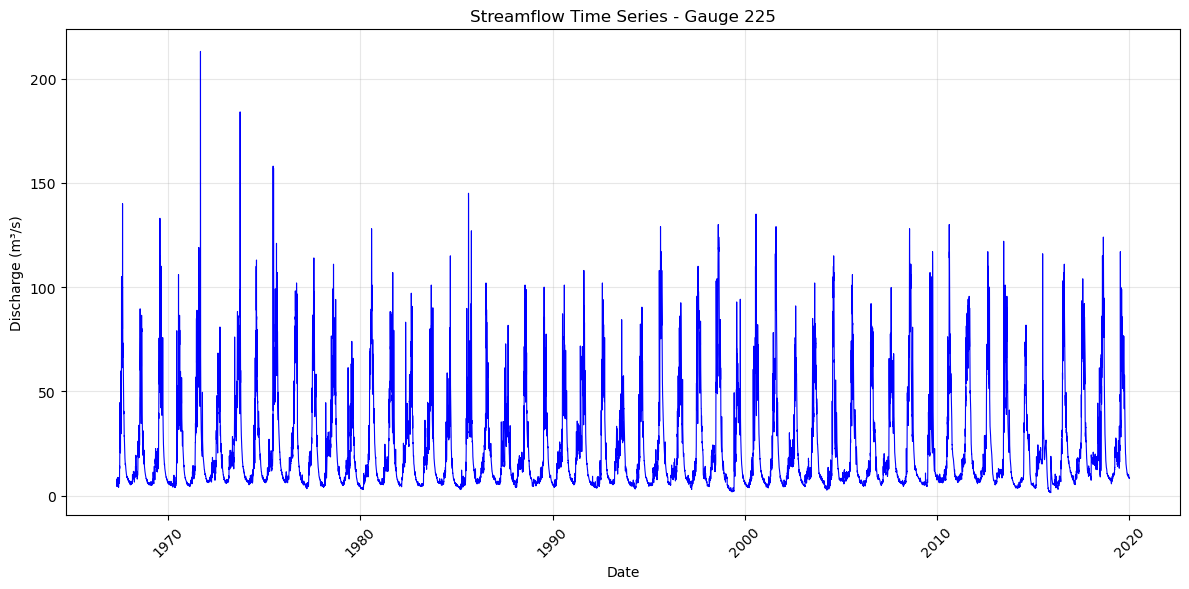

Plot saved to: /home/jberg/OneDrive/Raven_worldwide/01_data/streamflow/streamflow_225_plot.png

Data summary for gauge 225:
Date range: 1967-05-01 00:00:00 to 2019-12-31 00:00:00
Total records: 19238
Missing values: 0
Valid values: 19238

First few rows:
        date  Q_obs
0 1967-05-01   6.56
1 1967-05-02   6.01
2 1967-05-03   5.57
3 1967-05-04   5.27
4 1967-05-05   4.90


In [6]:
df_single = process_single_gauge("225", input_folder, output_folder, plot=True)
if df_single is not None:
    print(f"\nData summary for gauge 225:")
    print(f"Date range: {df_single['date'].min()} to {df_single['date'].max()}")
    print(f"Total records: {len(df_single)}")
    print(f"Missing values: {df_single['Q_obs'].isna().sum()}")
    print(f"Valid values: {len(df_single.dropna(subset=['Q_obs']))}")
    print(f"\nFirst few rows:")
    print(df_single.head())

Processing all gauges...
Found 14 gauge files: ['225', '251.6', '406.4', '428', '439.3', '446.1', '610', '620', '627.5', '647', '650', '668.5', '670', '684']

Processing 14 gauges...
--------------------------------------------------
Processing gauge 225...
Successfully processed gauge 225. Output saved to: /home/jberg/OneDrive/Raven_worldwide/01_data/streamflow/streamflow_225.csv


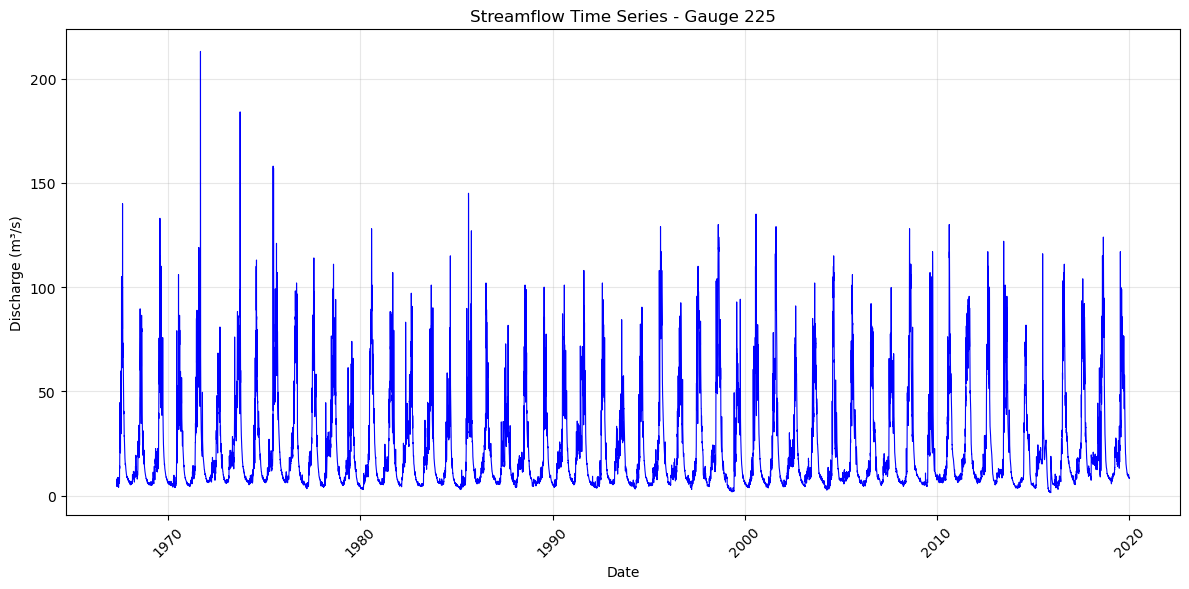

Plot saved to: /home/jberg/OneDrive/Raven_worldwide/01_data/streamflow/streamflow_225_plot.png
--------------------------------------------------
Processing gauge 251.6...
Successfully processed gauge 251.6. Output saved to: /home/jberg/OneDrive/Raven_worldwide/01_data/streamflow/streamflow_251.6.csv


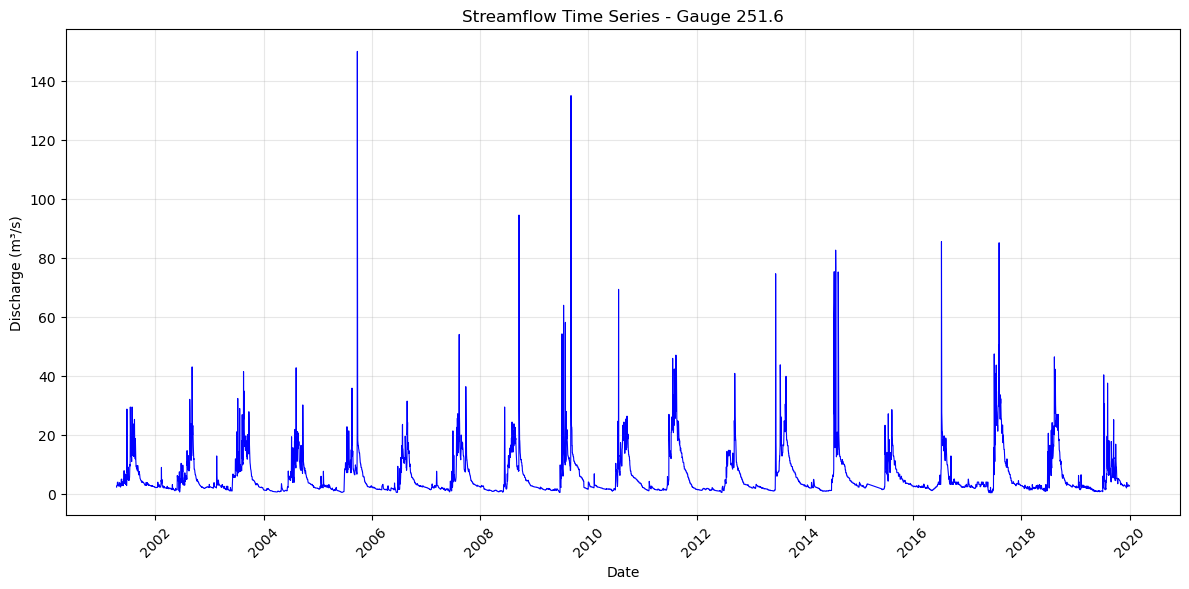

Plot saved to: /home/jberg/OneDrive/Raven_worldwide/01_data/streamflow/streamflow_251.6_plot.png
--------------------------------------------------
Processing gauge 406.4...
Successfully processed gauge 406.4. Output saved to: /home/jberg/OneDrive/Raven_worldwide/01_data/streamflow/streamflow_406.4.csv


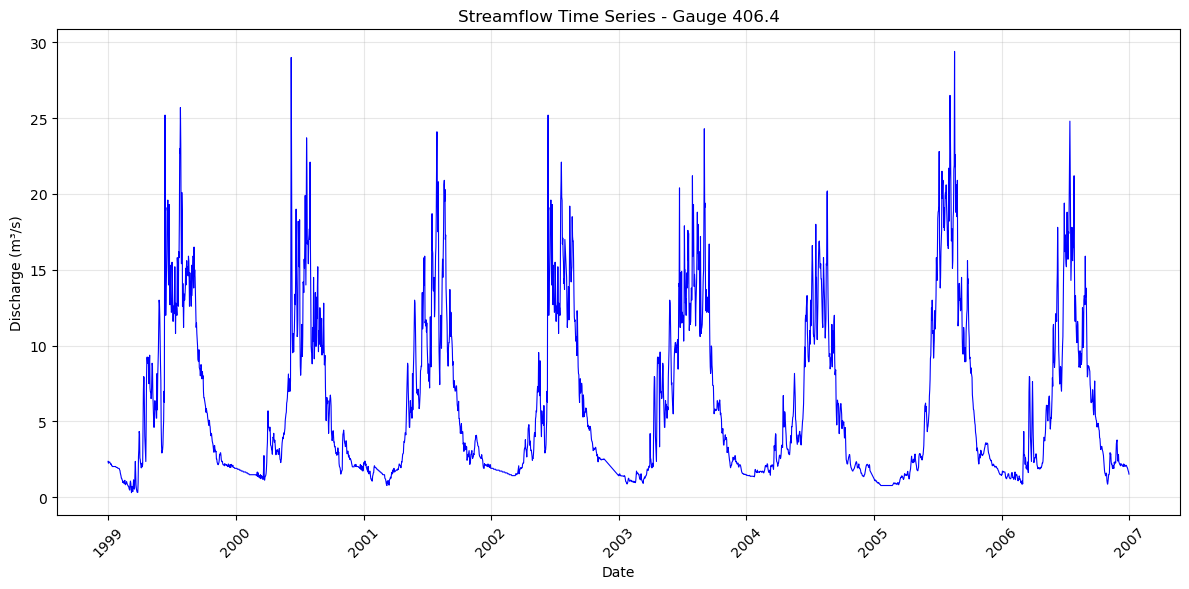

Plot saved to: /home/jberg/OneDrive/Raven_worldwide/01_data/streamflow/streamflow_406.4_plot.png
--------------------------------------------------
Processing gauge 428...
Successfully processed gauge 428. Output saved to: /home/jberg/OneDrive/Raven_worldwide/01_data/streamflow/streamflow_428.csv


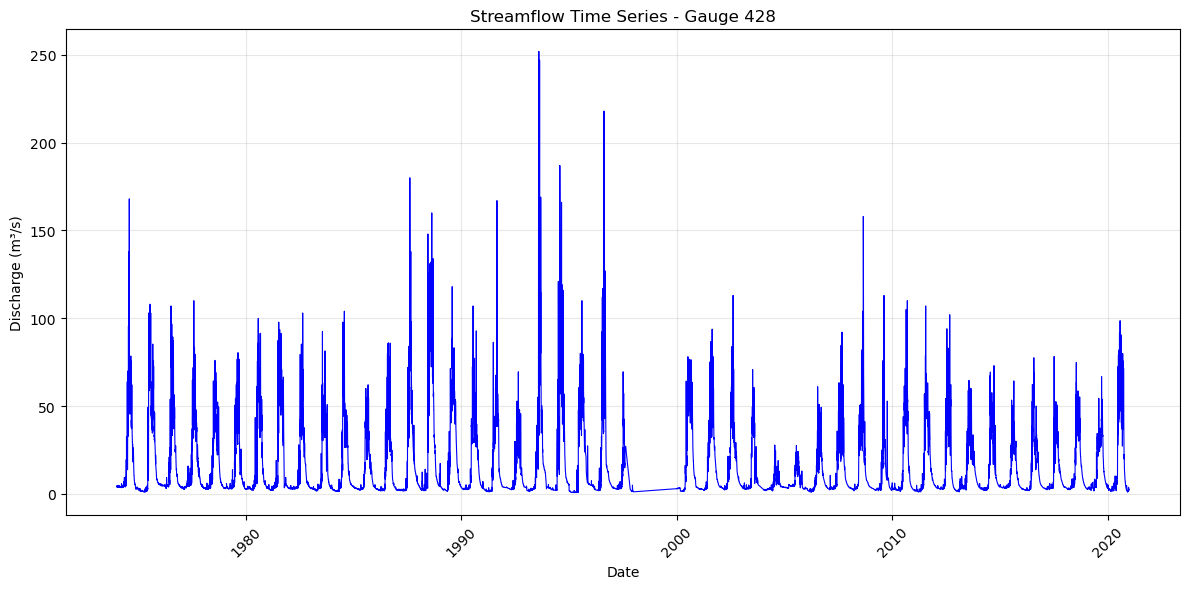

Plot saved to: /home/jberg/OneDrive/Raven_worldwide/01_data/streamflow/streamflow_428_plot.png
--------------------------------------------------
Processing gauge 439.3...
Successfully processed gauge 439.3. Output saved to: /home/jberg/OneDrive/Raven_worldwide/01_data/streamflow/streamflow_439.3.csv


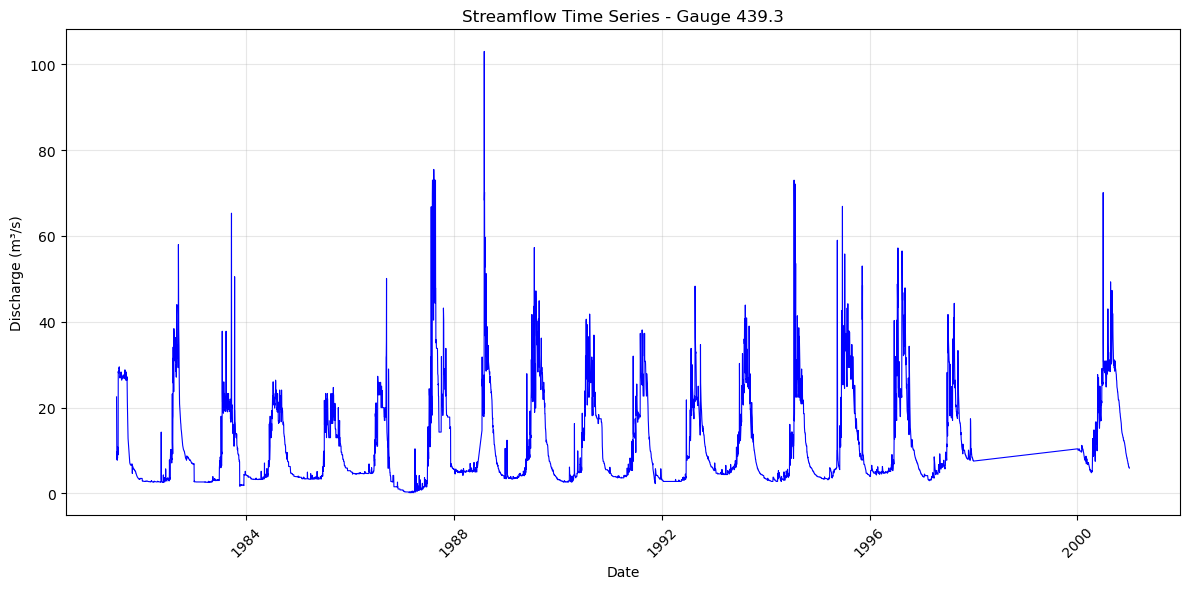

Plot saved to: /home/jberg/OneDrive/Raven_worldwide/01_data/streamflow/streamflow_439.3_plot.png
--------------------------------------------------
Processing gauge 446.1...
Successfully processed gauge 446.1. Output saved to: /home/jberg/OneDrive/Raven_worldwide/01_data/streamflow/streamflow_446.1.csv


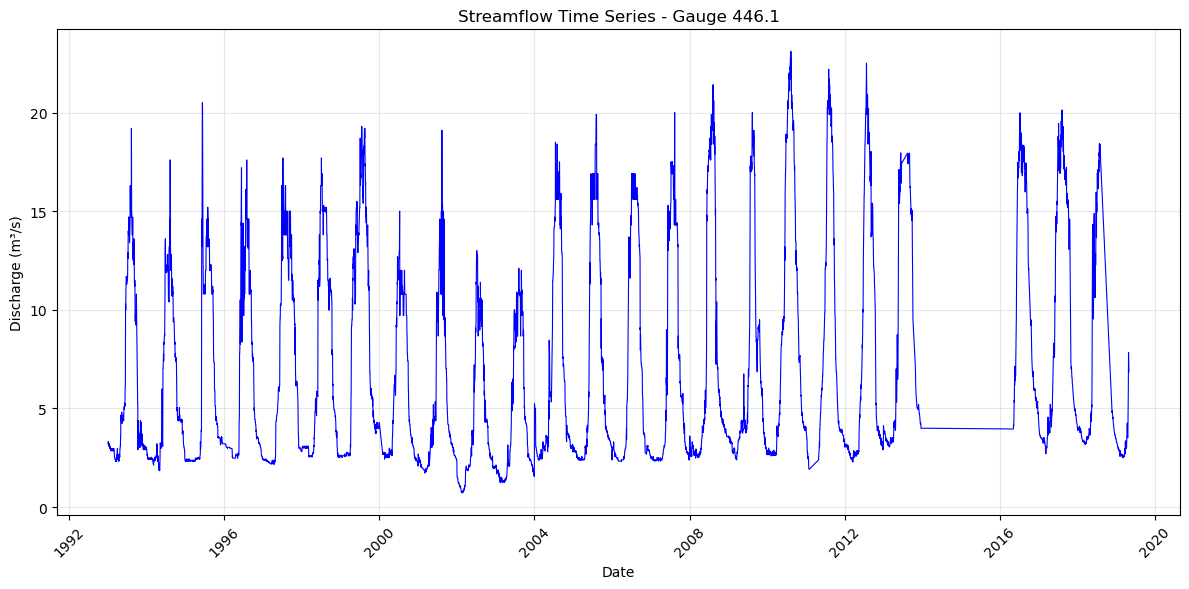

Plot saved to: /home/jberg/OneDrive/Raven_worldwide/01_data/streamflow/streamflow_446.1_plot.png
--------------------------------------------------
Processing gauge 610...
Successfully processed gauge 610. Output saved to: /home/jberg/OneDrive/Raven_worldwide/01_data/streamflow/streamflow_610.csv


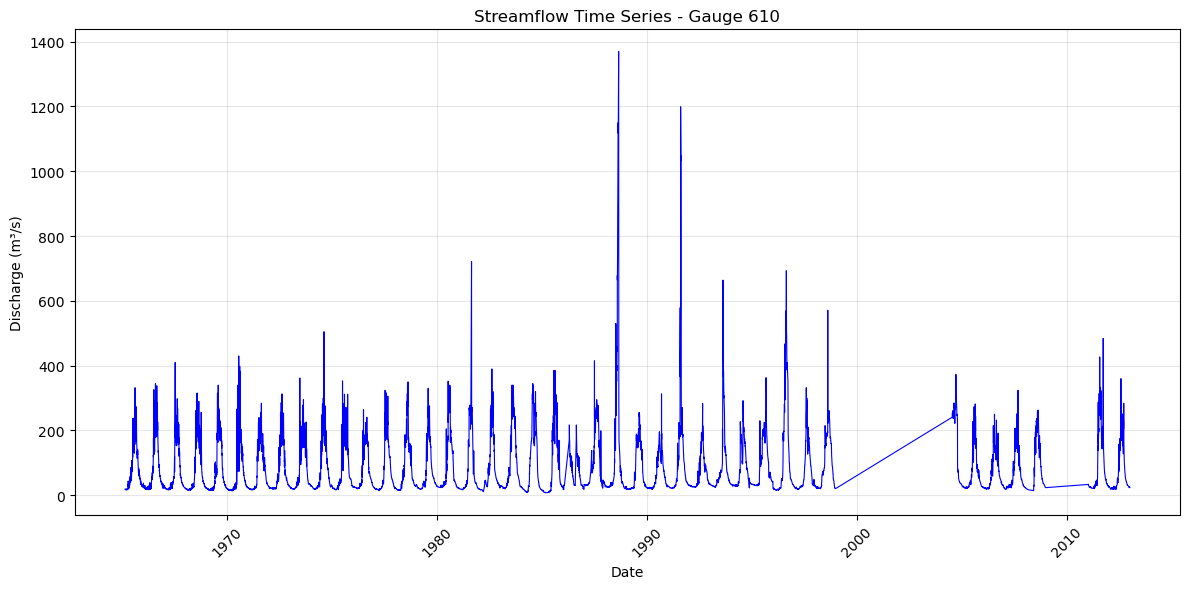

Plot saved to: /home/jberg/OneDrive/Raven_worldwide/01_data/streamflow/streamflow_610_plot.png
--------------------------------------------------
Processing gauge 620...
Successfully processed gauge 620. Output saved to: /home/jberg/OneDrive/Raven_worldwide/01_data/streamflow/streamflow_620.csv


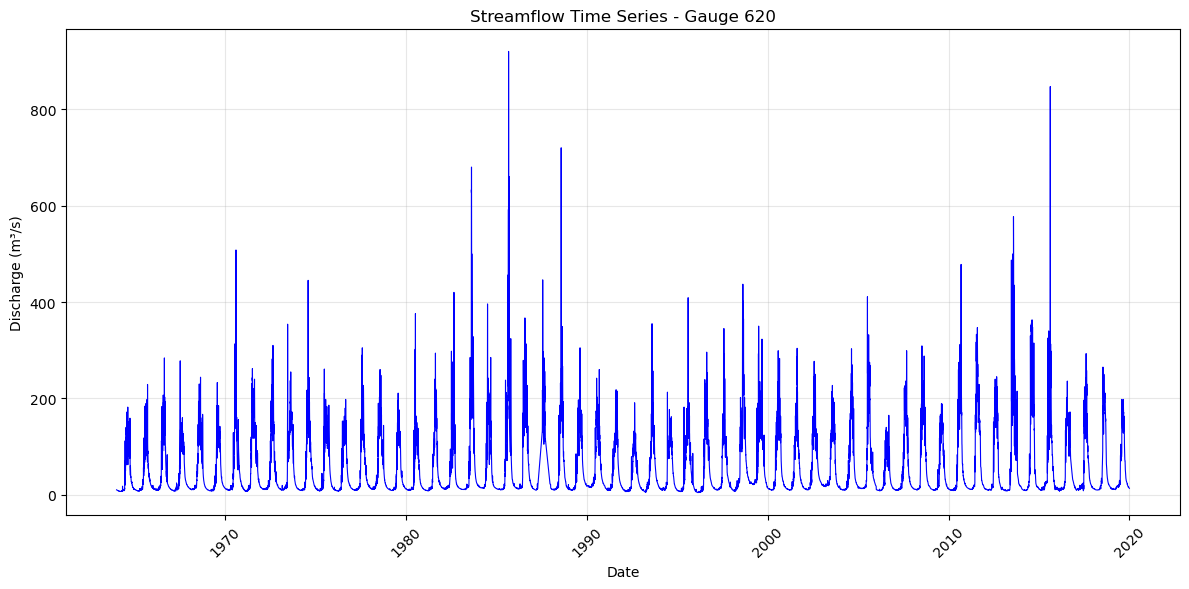

Plot saved to: /home/jberg/OneDrive/Raven_worldwide/01_data/streamflow/streamflow_620_plot.png
--------------------------------------------------
Processing gauge 627.5...
Successfully processed gauge 627.5. Output saved to: /home/jberg/OneDrive/Raven_worldwide/01_data/streamflow/streamflow_627.5.csv


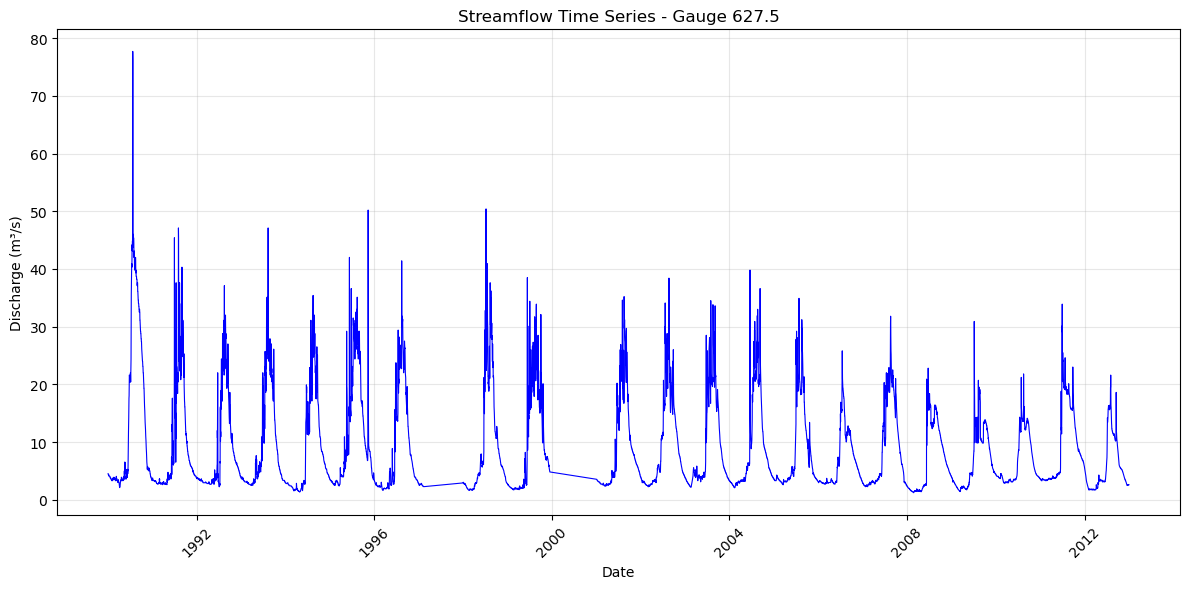

Plot saved to: /home/jberg/OneDrive/Raven_worldwide/01_data/streamflow/streamflow_627.5_plot.png
--------------------------------------------------
Processing gauge 647...
Successfully processed gauge 647. Output saved to: /home/jberg/OneDrive/Raven_worldwide/01_data/streamflow/streamflow_647.csv


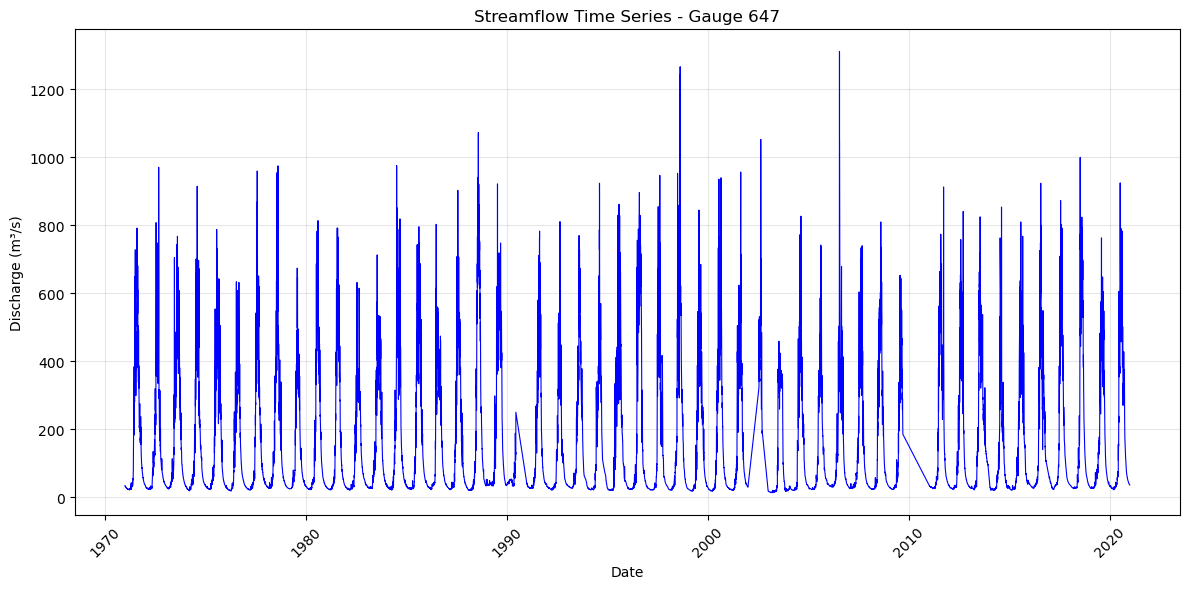

Plot saved to: /home/jberg/OneDrive/Raven_worldwide/01_data/streamflow/streamflow_647_plot.png
--------------------------------------------------
Processing gauge 650...
Successfully processed gauge 650. Output saved to: /home/jberg/OneDrive/Raven_worldwide/01_data/streamflow/streamflow_650.csv


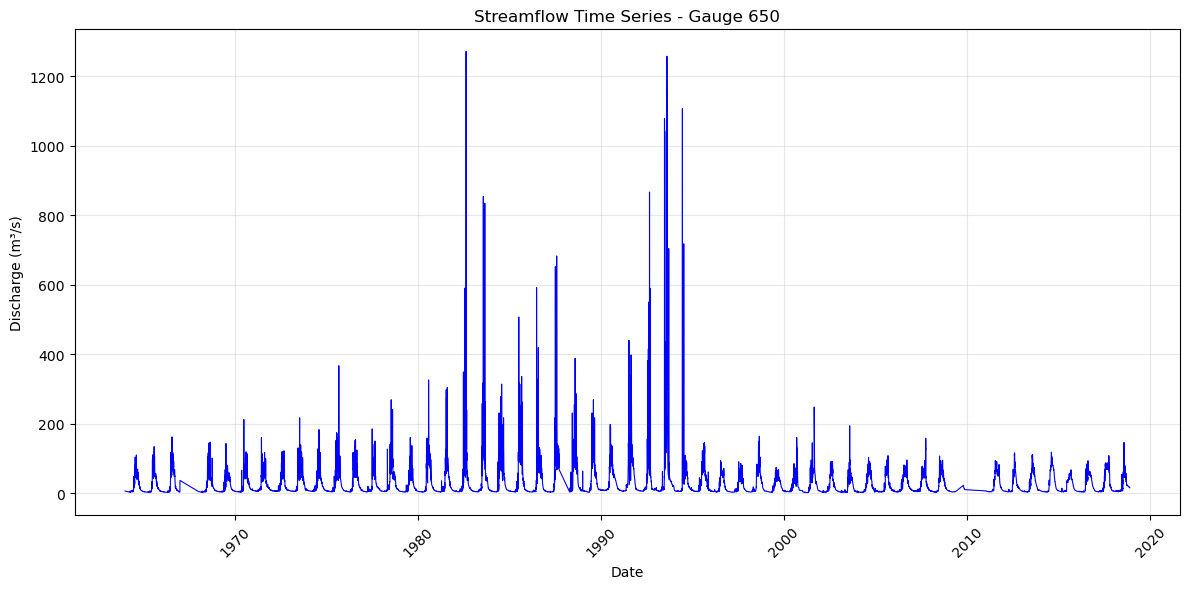

Plot saved to: /home/jberg/OneDrive/Raven_worldwide/01_data/streamflow/streamflow_650_plot.png
--------------------------------------------------
Processing gauge 668.5...
Successfully processed gauge 668.5. Output saved to: /home/jberg/OneDrive/Raven_worldwide/01_data/streamflow/streamflow_668.5.csv


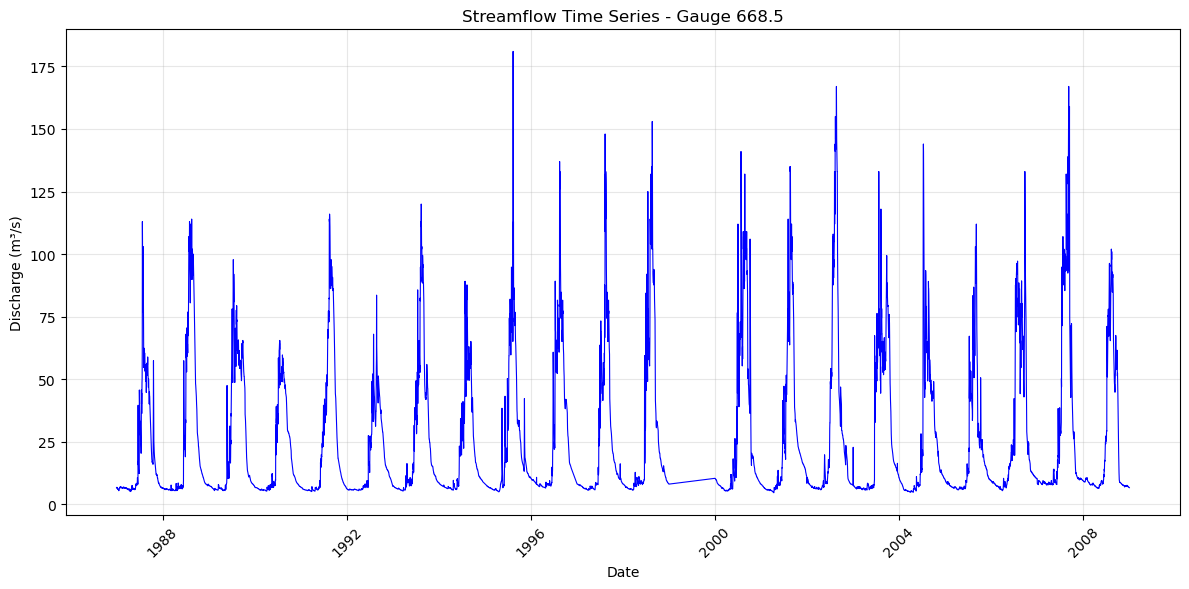

Plot saved to: /home/jberg/OneDrive/Raven_worldwide/01_data/streamflow/streamflow_668.5_plot.png
--------------------------------------------------
Processing gauge 670...
Successfully processed gauge 670. Output saved to: /home/jberg/OneDrive/Raven_worldwide/01_data/streamflow/streamflow_670.csv


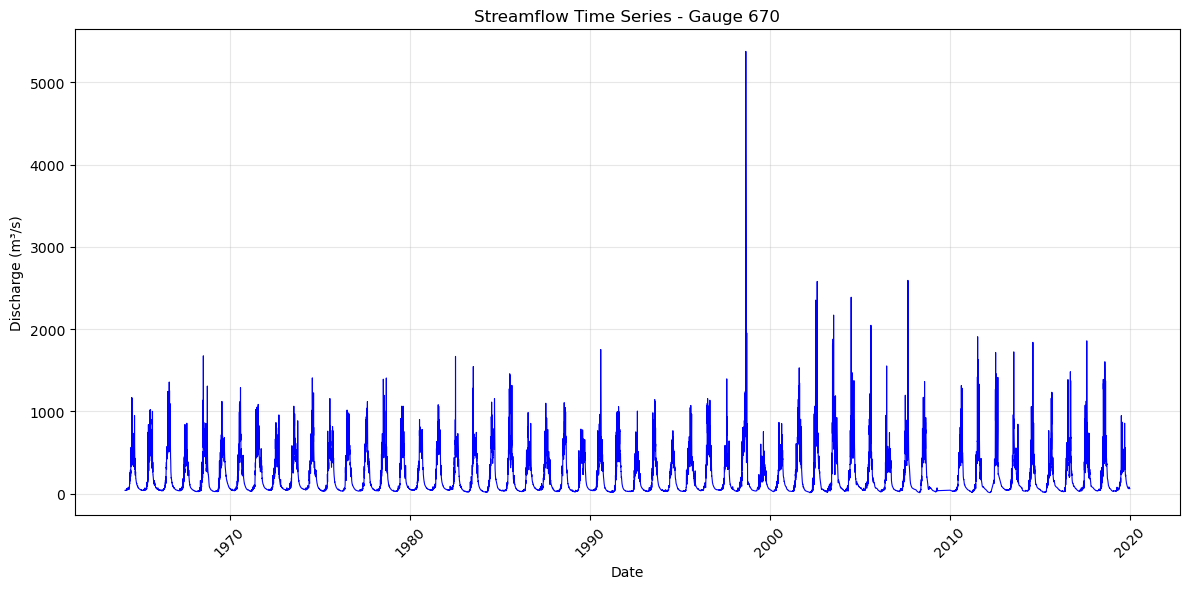

Plot saved to: /home/jberg/OneDrive/Raven_worldwide/01_data/streamflow/streamflow_670_plot.png
--------------------------------------------------
Processing gauge 684...
Successfully processed gauge 684. Output saved to: /home/jberg/OneDrive/Raven_worldwide/01_data/streamflow/streamflow_684.csv


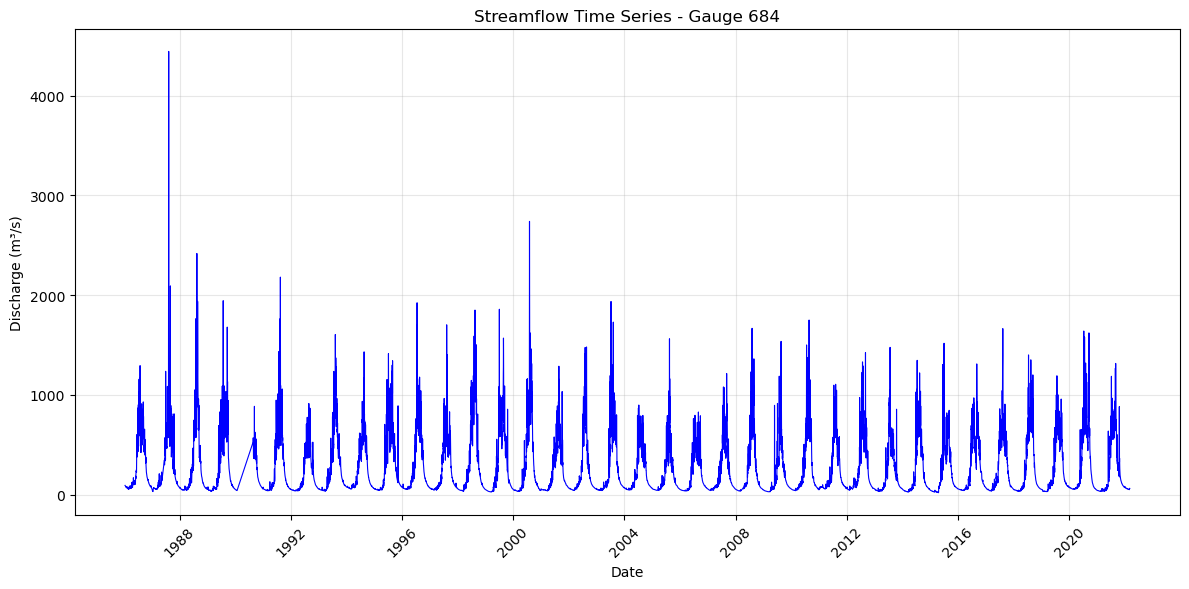

Plot saved to: /home/jberg/OneDrive/Raven_worldwide/01_data/streamflow/streamflow_684_plot.png
--------------------------------------------------

Processing complete!
Successfully processed: 14 gauges
Failed: 0 gauges

Summary of all processed gauges:
Gauge 225: 19238/19238 valid records (100.0% complete)
Gauge 251.6: 6725/6836 valid records (98.4% complete)
Gauge 406.4: 2867/2922 valid records (98.1% complete)
Gauge 428: 16241/17167 valid records (94.6% complete)
Gauge 439.3: 6216/7121 valid records (87.3% complete)
Gauge 446.1: 8399/9619 valid records (87.3% complete)
Gauge 610: 14462/17485 valid records (82.7% complete)
Gauge 620: 20271/20454 valid records (99.1% complete)
Gauge 627.5: 7696/8401 valid records (91.6% complete)
Gauge 647: 17090/18263 valid records (93.6% complete)
Gauge 650: 18794/20044 valid records (93.8% complete)
Gauge 668.5: 7584/8036 valid records (94.4% complete)
Gauge 670: 19952/20385 valid records (97.9% complete)
Gauge 684: 12908/13201 valid records (97.8% 

In [7]:
print("Processing all gauges...")
all_results = process_all_gauges(input_folder, output_folder, plot=True)
    
if all_results:
    print(f"\nSummary of all processed gauges:")
    for gauge_id, df in all_results.items():
        valid_data = len(df.dropna(subset=['Q_obs']))
        total_data = len(df)
        print(f"Gauge {gauge_id}: {valid_data}/{total_data} valid records "
                f"({valid_data/total_data*100:.1f}% complete)")

In [ ]:
############# Excel papredata ###########

In [ ]:
def process_excel_streamflow(input_folder, output_folder, plot=True):
    """
    Process Excel streamflow files and convert them to CSV format.
    
    Parameters:
    input_folder (str): Path to folder containing Excel files
    output_folder (str): Path to folder where CSV files will be saved
    plot (bool): Whether to create time series plots for each gauge
    
    Returns:
    dict: Dictionary with gauge_ids as keys and processed DataFrames as values
    """
    
    # Find all Excel files
    excel_files = glob.glob(os.path.join(input_folder, "*.xlsx"))
    excel_files.extend(glob.glob(os.path.join(input_folder, "*.xls")))
    
    if not excel_files:
        print("No Excel files found in the input folder!")
        return {}
    
    print(f"Found {len(excel_files)} Excel files: {[os.path.basename(f) for f in excel_files]}")
    
    # Create output directory if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)
    
    results = {}
    successful = 0
    failed = 0
    
    print(f"\nProcessing {len(excel_files)} Excel files...")
    print("-" * 50)
    
    for excel_file in excel_files:
        filename = os.path.basename(excel_file)
        print(f"Processing {filename}...")
        
        try:
            # Read Excel file
            df = pd.read_excel(excel_file)
            
            # Check if required columns exist
            required_cols = ['Date', 'Value', 'Station', 'Sensor']
            missing_cols = [col for col in required_cols if col not in df.columns]
            
            if missing_cols:
                print(f"  ❌ Missing columns: {missing_cols}")
                failed += 1
                continue
            
            # Get unique stations in this file
            stations = df['Station'].unique()
            print(f"  Found stations: {stations}")
            
            # Process each station separately
            for station in stations:
                station_data = df[df['Station'] == station].copy()
                
                if len(station_data) == 0:
                    continue
                
                # Clean station name to use as gauge_id
                gauge_id = str(station).replace(' ', '_').replace('/', '_')
                
                print(f"    Processing station: {station} (ID: {gauge_id})")
                
                # Convert Excel serial dates to datetime
                try:
                    # Handle both numeric and already-datetime formats
                    if pd.api.types.is_numeric_dtype(station_data['Date']):
                        # Convert Excel serial date to datetime
                        # Excel serial date: days since 1900-01-01 (with 1900 leap year bug)
                        station_data['date'] = pd.to_datetime(station_data['Date'], origin='1899-12-30', unit='D')
                    else:
                        # Try to parse as regular datetime
                        station_data['date'] = pd.to_datetime(station_data['Date'])
                except Exception as e:
                    print(f"    ❌ Error converting dates for {station}: {e}")
                    continue
                
                # Prepare flow data
                station_data['Q_obs'] = station_data['Value']
                
                
                # Keep only date and Q_obs columns
                final_data = station_data[['date', 'Q_obs']].copy()
                
                # Sort by date
                final_data = final_data.sort_values('date').reset_index(drop=True)
                
                # Create complete date range and fill missing values
                if len(final_data) > 0:
                    date_range = pd.date_range(start=final_data['date'].min(), 
                                             end=final_data['date'].max(), 
                                             freq='D')
                    
                    # ✅ UPDATED: Reindex to include all dates, keeping NaN for missing values
                    df_complete = final_data.set_index('date').reindex(date_range).reset_index()
                    df_complete.columns = ['date', 'Q_obs']
                else:
                    df_complete = final_data
                
                # Save to CSV
                output_file = os.path.join(output_folder, f"streamflow_{gauge_id}.csv")
                df_complete.to_csv(output_file, index=False)
                print(f"    ✅ Saved: {output_file}")
                
                # Create plot if requested
                if plot and len(df_complete) > 0:
                    plt.figure(figsize=(12, 6))
                    
                    # ✅ UPDATED: Only plot non-NaN values for better visualization
                    plot_data = df_complete.dropna(subset=['Q_obs']).copy()
                    
                    if len(plot_data) > 0:
                        plt.plot(plot_data['date'], plot_data['Q_obs'], 'b-', linewidth=0.8)
                        plt.title(f'Streamflow Time Series - {station} (ID: {gauge_id})')
                        plt.xlabel('Date')
                        plt.ylabel('Discharge (m³/s)')
                        plt.grid(True, alpha=0.3)
                        plt.xticks(rotation=45)
                        plt.tight_layout()
                        
                        # Save plot
                        plot_file = os.path.join(output_folder, f"streamflow_{gauge_id}_plot.png")
                        plt.savefig(plot_file, dpi=300, bbox_inches='tight')
                        plt.show()
                        
                        print(f"    📊 Plot saved: {plot_file}")
                    else:
                        print(f"    ⚠️ No valid data to plot for {station}")
                
                # Store in results
                results[gauge_id] = df_complete
                
            successful += 1
            
        except Exception as e:
            print(f"  ❌ Error processing {filename}: {str(e)}")
            failed += 1
        
        print("-" * 50)
    
    print(f"\nProcessing complete!")
    print(f"Successfully processed: {successful} files")
    print(f"Failed: {failed} files")
    print(f"Total stations processed: {len(results)}")
    
    return results

Processing Excel streamflow files...
Found 10 Excel files: ['Tauche_QH.xlsx', 'Phakding_QH.xlsx', 'Tauche_QJ.xlsx', 'Kharikhola_QH.xlsx', 'Pheriche_QJ.xlsx', 'Dingboche_QH.xlsx', 'Pheriche_QH.xlsx', 'Phakding_QJ.xlsx', 'Kharikhola_QJ.xlsx', 'Dingboche_QJ.xlsx']

Processing 10 Excel files...
--------------------------------------------------
Processing Tauche_QH.xlsx...
  Found stations: [668.03]
    Processing station: 668.03 (ID: 668.03)
    ✅ Saved: /home/jberg/OneDrive/Raven_worldwide/01_data/streamflow/streamflow_668.03.csv


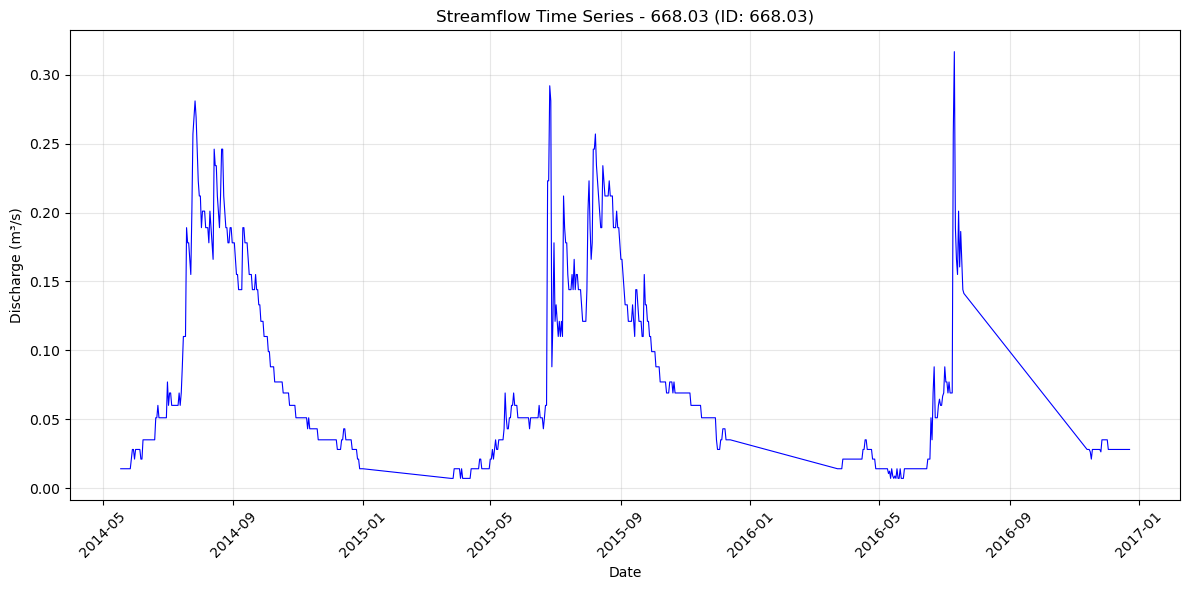

    📊 Plot saved: /home/jberg/OneDrive/Raven_worldwide/01_data/streamflow/streamflow_668.03_plot.png
--------------------------------------------------
Processing Phakding_QH.xlsx...
  Found stations: [668.3]
    Processing station: 668.3 (ID: 668.3)
    ✅ Saved: /home/jberg/OneDrive/Raven_worldwide/01_data/streamflow/streamflow_668.3.csv


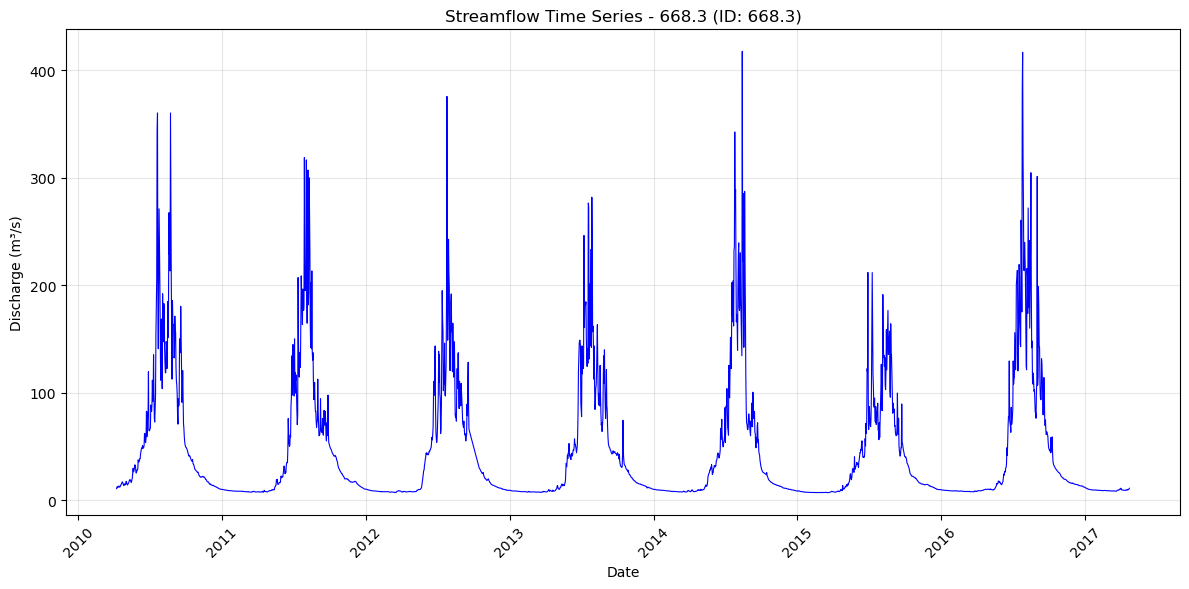

    📊 Plot saved: /home/jberg/OneDrive/Raven_worldwide/01_data/streamflow/streamflow_668.3_plot.png
--------------------------------------------------
Processing Tauche_QJ.xlsx...
  Found stations: [668.03]
    Processing station: 668.03 (ID: 668.03)
    ✅ Saved: /home/jberg/OneDrive/Raven_worldwide/01_data/streamflow/streamflow_668.03.csv


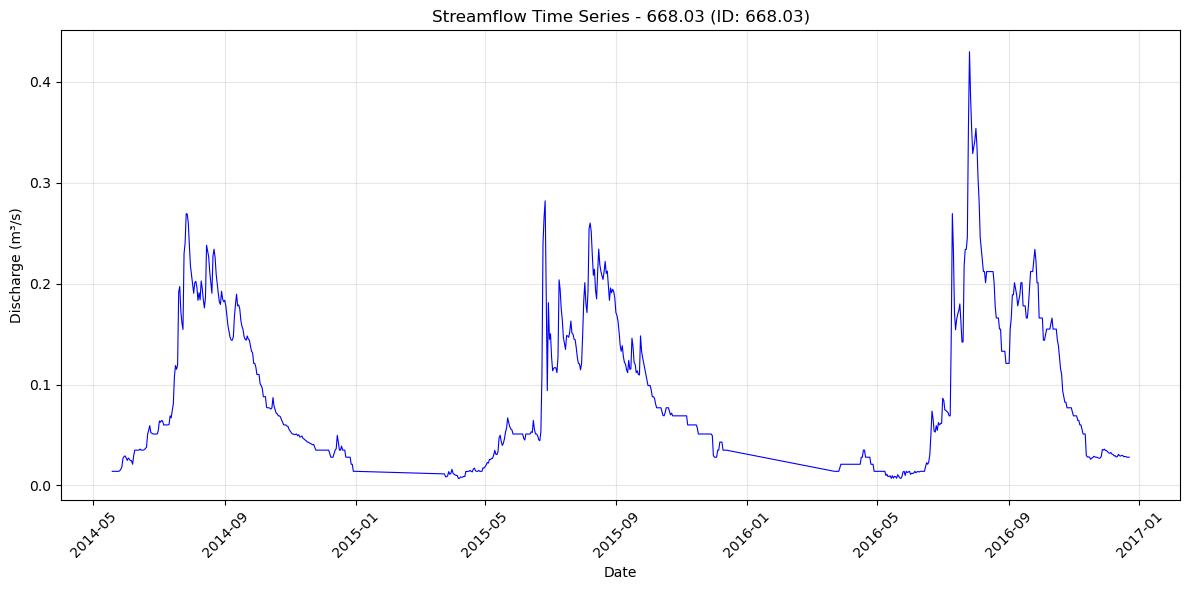

    📊 Plot saved: /home/jberg/OneDrive/Raven_worldwide/01_data/streamflow/streamflow_668.03_plot.png
--------------------------------------------------
Processing Kharikhola_QH.xlsx...
  Found stations: [668.7]
    Processing station: 668.7 (ID: 668.7)
    ✅ Saved: /home/jberg/OneDrive/Raven_worldwide/01_data/streamflow/streamflow_668.7.csv


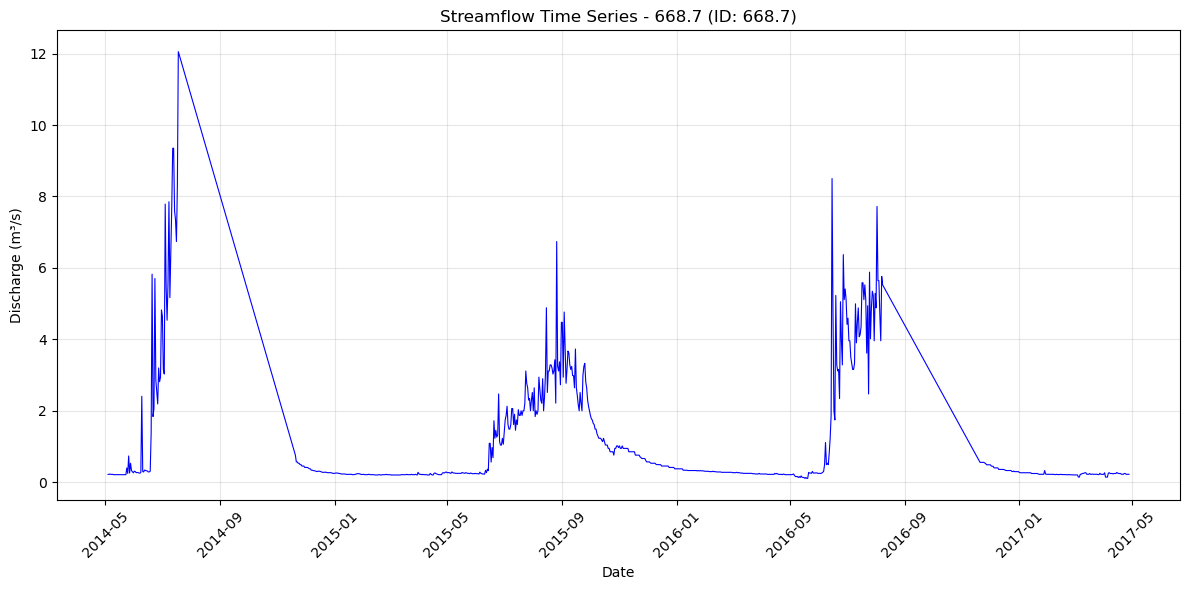

    📊 Plot saved: /home/jberg/OneDrive/Raven_worldwide/01_data/streamflow/streamflow_668.7_plot.png
--------------------------------------------------
Processing Pheriche_QJ.xlsx...
  Found stations: [666]
    Processing station: 666 (ID: 666)
    ✅ Saved: /home/jberg/OneDrive/Raven_worldwide/01_data/streamflow/streamflow_666.csv


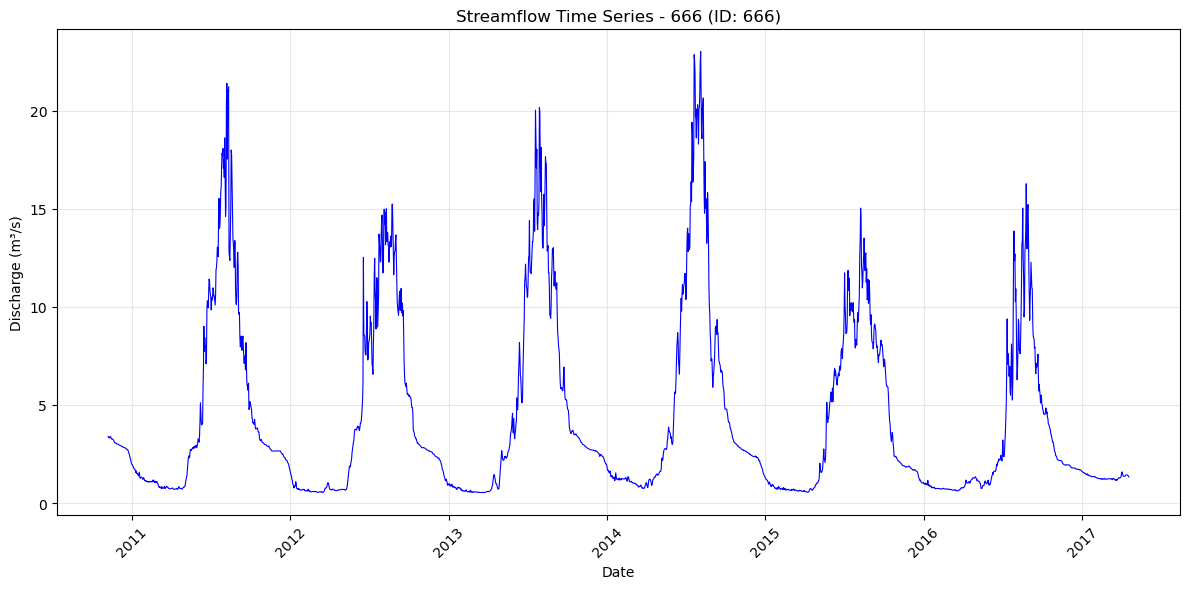

    📊 Plot saved: /home/jberg/OneDrive/Raven_worldwide/01_data/streamflow/streamflow_666_plot.png
--------------------------------------------------
Processing Dingboche_QH.xlsx...
  Found stations: [667]
    Processing station: 667 (ID: 667)
    ✅ Saved: /home/jberg/OneDrive/Raven_worldwide/01_data/streamflow/streamflow_667.csv


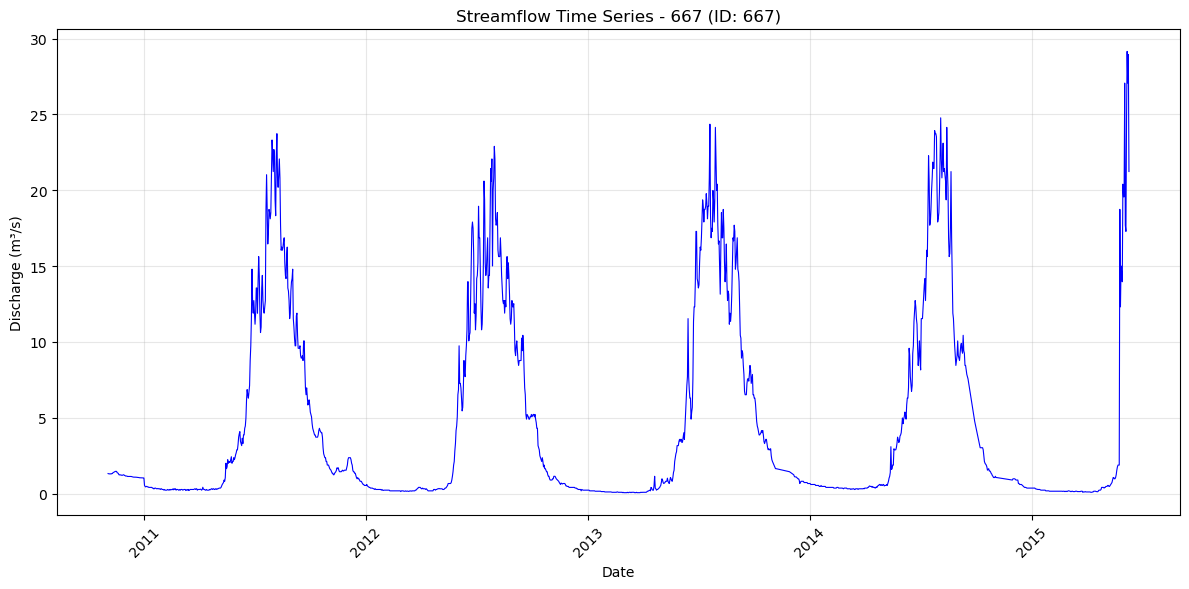

    📊 Plot saved: /home/jberg/OneDrive/Raven_worldwide/01_data/streamflow/streamflow_667_plot.png
--------------------------------------------------
Processing Pheriche_QH.xlsx...
  Found stations: [666]
    Processing station: 666 (ID: 666)
    ✅ Saved: /home/jberg/OneDrive/Raven_worldwide/01_data/streamflow/streamflow_666.csv


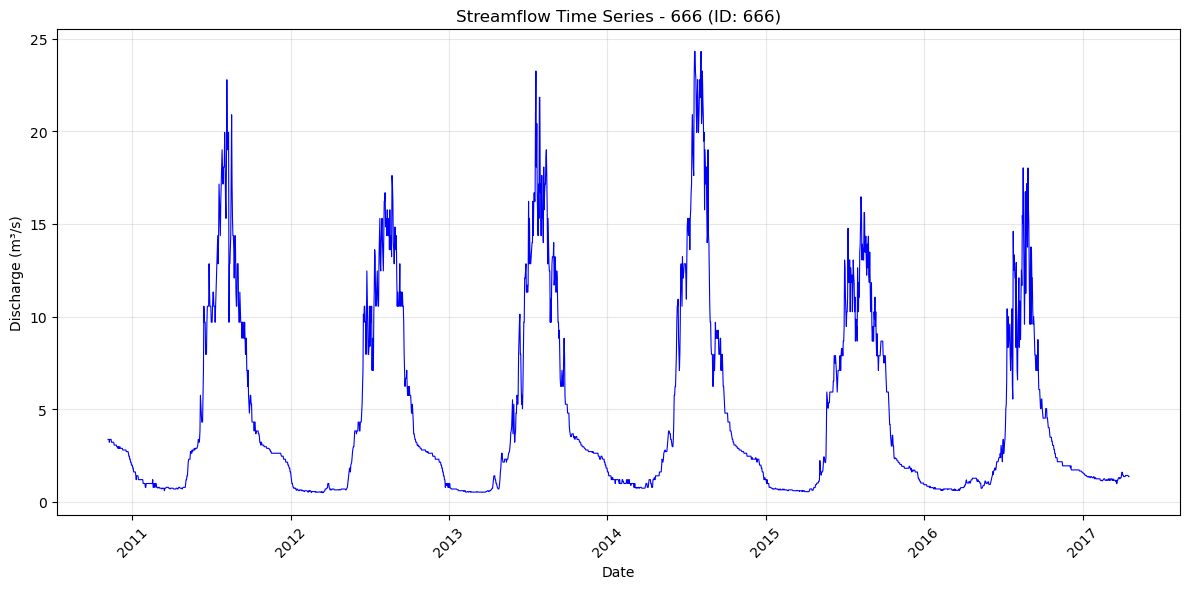

    📊 Plot saved: /home/jberg/OneDrive/Raven_worldwide/01_data/streamflow/streamflow_666_plot.png
--------------------------------------------------
Processing Phakding_QJ.xlsx...
  Found stations: [668.3]
    Processing station: 668.3 (ID: 668.3)
    ✅ Saved: /home/jberg/OneDrive/Raven_worldwide/01_data/streamflow/streamflow_668.3.csv


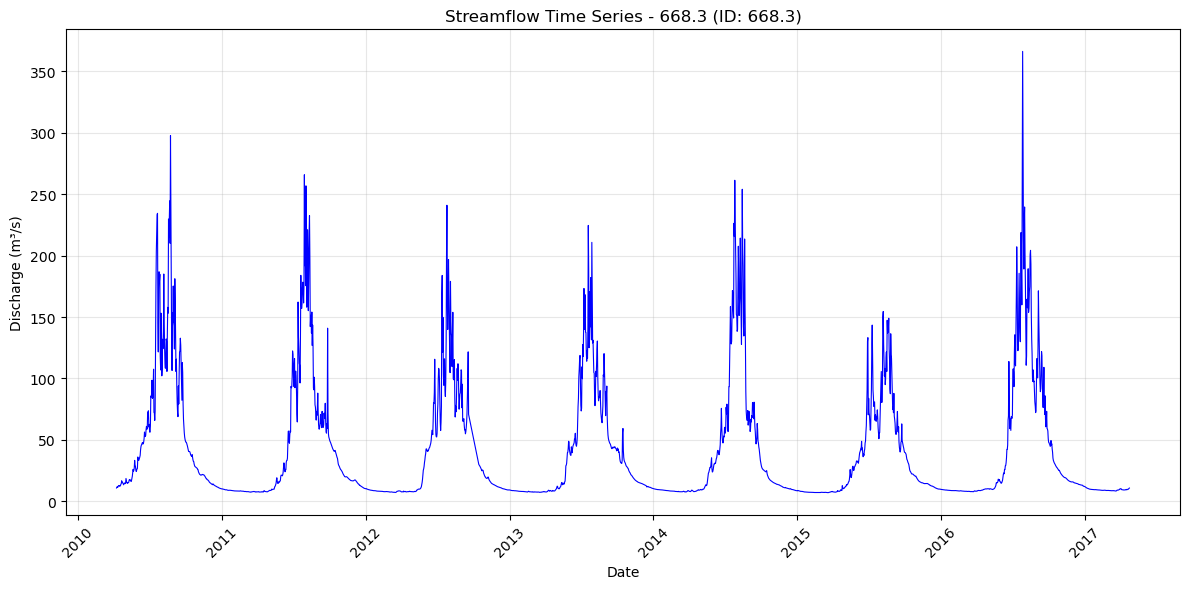

    📊 Plot saved: /home/jberg/OneDrive/Raven_worldwide/01_data/streamflow/streamflow_668.3_plot.png
--------------------------------------------------
Processing Kharikhola_QJ.xlsx...
  Found stations: [668.7]
    Processing station: 668.7 (ID: 668.7)
    ✅ Saved: /home/jberg/OneDrive/Raven_worldwide/01_data/streamflow/streamflow_668.7.csv


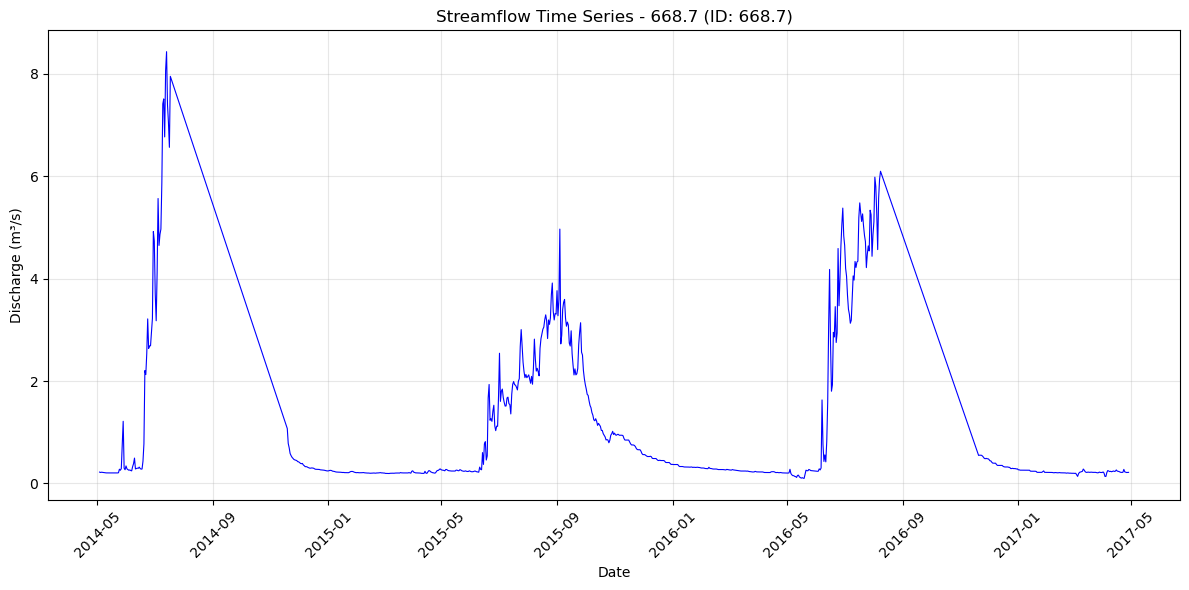

    📊 Plot saved: /home/jberg/OneDrive/Raven_worldwide/01_data/streamflow/streamflow_668.7_plot.png
--------------------------------------------------
Processing Dingboche_QJ.xlsx...
  Found stations: [667]
    Processing station: 667 (ID: 667)
    ✅ Saved: /home/jberg/OneDrive/Raven_worldwide/01_data/streamflow/streamflow_667.csv


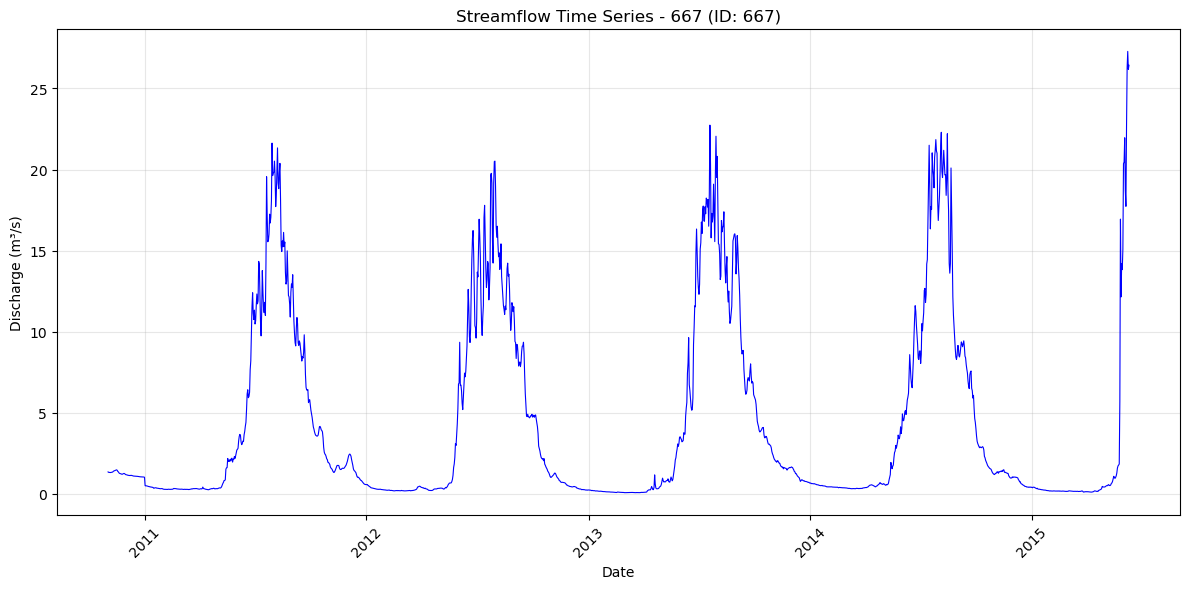

    📊 Plot saved: /home/jberg/OneDrive/Raven_worldwide/01_data/streamflow/streamflow_667_plot.png
--------------------------------------------------

Processing complete!
Successfully processed: 10 files
Failed: 0 files
Total stations processed: 5

Summary of Excel processed gauges:
Gauge 668.03: 768/952 valid records (80.7% complete)
Gauge 668.3: 2543/2574 valid records (98.8% complete)
Gauge 668.7: 865/1092 valid records (79.2% complete)
Gauge 666: 2354/2357 valid records (99.9% complete)
Gauge 667: 1682/1683 valid records (99.9% complete)


In [9]:
# Define paths for Excel files
excel_input_folder = "/home/jberg/OneDrive/Data_collection_Himalaya/streamflow/Nepal/papredata_full/streamflow"
excel_output_folder = "/home/jberg/OneDrive/Raven_worldwide/01_data/streamflow"

# Process all Excel files
print("Processing Excel streamflow files...")
excel_results = process_excel_streamflow(excel_input_folder, excel_output_folder, plot=True)

# ✅ UPDATED: Summary statistics for Excel files using NaN handling
if excel_results:
    print(f"\nSummary of Excel processed gauges:")
    for gauge_id, df in excel_results.items():
        valid_data = len(df.dropna(subset=['Q_obs']))
        total_data = len(df)
        print(f"Gauge {gauge_id}: {valid_data}/{total_data} valid records "
              f"({valid_data/total_data*100:.1f}% complete)")

In [ ]:
########## other random data collected ###########

In [10]:
# Convert Excel file to DFL text format
import pandas as pd
import os
from datetime import datetime

# Define file paths
excel_file = "/home/jberg/OneDrive/Data_collection_Himalaya/streamflow/Nepal/other_streamflow_files/DFL_670.xlsx"
txt_file = "/home/jberg/OneDrive/Data_collection_Himalaya/streamflow/Nepal/other_streamflow_files/DFL_670.txt"

# Check if Excel file exists
if os.path.exists(excel_file):
    print(f"Reading Excel file: {excel_file}")
    
    # Read the Excel file
    df = pd.read_excel(excel_file)
    
    print(f"Excel file shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    print(f"First few rows:")
    print(df.head())
    
    # Extract data columns
    date_col = df.columns[0]  # 'Daily Flow of Station: 670 in m3/s'
    flow_col = df.columns[1]  # 'Unnamed: 1'
    
    # Rename columns for easier handling
    df.columns = ['date_str', 'flow']
    
    # Convert date strings to datetime
    df['date'] = pd.to_datetime(df['date_str'], format='%d/%b/%Y')
    
    # Get year range
    years = sorted(df['date'].dt.year.unique())
    
    # Create the DFL format text file
    with open(txt_file, 'w') as f:
        # Write header
        f.write(f"Daily Flow of Station: 670 in m3/s\n")
        
        # Write years list
        for year in years:
            f.write(f" {year} \n")
        
        # Write data in DD/MMM/YYYY,flow format
        for _, row in df.iterrows():
            date_formatted = row['date'].strftime('%d/%b/%Y')
            flow_value = row['flow']
            f.write(f"{date_formatted},{flow_value}\n")
    
    print(f"✅ Successfully converted to DFL format: {txt_file}")
    
    # Verify the text file was created
    if os.path.exists(txt_file):
        print(f"Text file size: {os.path.getsize(txt_file)} bytes")
        
        # Show first few lines of the output
        print(f"\nFirst 20 lines of output file:")
        with open(txt_file, 'r') as f:
            lines = f.readlines()[:20]
            for line in lines:
                print(line.strip())
    
else:
    print(f"❌ Excel file not found: {excel_file}")

Reading Excel file: /home/jberg/OneDrive/Data_collection_Himalaya/streamflow/Nepal/other_streamflow_files/DFL_670.xlsx
Excel file shape: (19952, 2)
Columns: ['Daily Flow of Station: 670 in m3/s', 'Unnamed: 1']
First few rows:
  Daily Flow of Station: 670 in m3/s  Unnamed: 1
0                        10/Mar/1964        41.4
1                        11/Mar/1964        41.4
2                        12/Mar/1964        41.4
3                        13/Mar/1964        41.4
4                        14/Mar/1964        40.5
✅ Successfully converted to DFL format: /home/jberg/OneDrive/Data_collection_Himalaya/streamflow/Nepal/other_streamflow_files/DFL_670.txt
Text file size: 348462 bytes

First 20 lines of output file:
Daily Flow of Station: 670 in m3/s
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982


In [11]:
# First, let's examine the hourly data structure
hourly_file = "/home/jberg/OneDrive/Data_collection_Himalaya/streamflow/Nepal/other_streamflow_files/LangtangKholaDischarge_Kyanjing.csv"
government_file = "/home/jberg/OneDrive/Data_collection_Himalaya/streamflow/Nepal/other_streamflow_files/DFL_446.1.txt"

# Read the hourly data
print("Reading hourly data...")
hourly_data = pd.read_csv(hourly_file)
print("Hourly data columns:", hourly_data.columns.tolist())
print("First few rows of hourly data:")
print(hourly_data.head())
print(f"Date range: {hourly_data['DATE'].min()} to {hourly_data['DATE'].max()}")

Reading hourly data...
Hourly data columns: ['DATE', 'TIME', 'H [m]', 'Q [m3/s]', 'water temperature [C]']
First few rows of hourly data:
         DATE      TIME  H [m]  Q [m3/s]  water temperature [C]
0  2012-03-22  00:00:00    NaN       NaN                    NaN
1  2012-03-22  01:00:00    NaN       NaN                    NaN
2  2012-03-22  02:00:00    NaN       NaN                    NaN
3  2012-03-22  03:00:00    NaN       NaN                    NaN
4  2012-03-22  04:00:00    NaN       NaN                    NaN
Date range: 2012-03-22 to 2019-05-04


In [12]:
# Convert hourly data to daily data
def process_hourly_to_daily(hourly_data):
    """Convert hourly discharge data to daily averages"""
    
    # Combine DATE and TIME columns to create datetime
    hourly_data['datetime'] = pd.to_datetime(hourly_data['DATE'] + ' ' + hourly_data['TIME'])
    
    # Extract date only for grouping
    hourly_data['date'] = hourly_data['datetime'].dt.date
    
    # Calculate daily statistics
    daily_data = hourly_data.groupby('date').agg({
        'Q [m3/s]': ['mean', 'min', 'max', 'count']
    }).round(3)
    
    # Flatten column names
    daily_data.columns = ['Q_mean', 'Q_min', 'Q_max', 'hourly_count']
    
    # Reset index to make date a column
    daily_data = daily_data.reset_index()
    
    # Convert date back to datetime for easier handling
    daily_data['date'] = pd.to_datetime(daily_data['date'])
    
    # Filter out days with insufficient data (less than 20 hours of data)
    daily_data = daily_data[daily_data['hourly_count'] >= 20]
    
    return daily_data

# Process the hourly data
daily_from_hourly = process_hourly_to_daily(hourly_data)
print("Daily data from hourly:")
print(daily_from_hourly.head())
print(f"Date range: {daily_from_hourly['date'].min()} to {daily_from_hourly['date'].max()}")

Daily data from hourly:
         date  Q_mean  Q_min  Q_max  hourly_count
10 2012-04-01   3.864  3.384  4.360            23
11 2012-04-02   4.151  3.859  4.437            24
12 2012-04-03   4.081  3.913  4.373            24
13 2012-04-04   3.994  3.901  4.154            24
14 2012-04-05   3.945  3.738  4.334            24
Date range: 2012-04-01 00:00:00 to 2019-05-03 00:00:00


In [13]:
# Read and process the government data
def process_government_data(file_path):
    """Read and process the government station data"""
    
    daily_govt = []
    
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    # Skip header lines and process data
    for line in lines:
        line = line.strip()
        if ',' in line and '/' in line:  # Data lines have date,discharge format
            try:
                date_str, discharge_str = line.split(',')
                discharge = float(discharge_str)
                
                # Parse date (format: DD/MMM/YYYY)
                date = pd.to_datetime(date_str, format='%d/%b/%Y')
                
                daily_govt.append({
                    'date': date,
                    'Q_govt': discharge
                })
            except:
                continue
    
    return pd.DataFrame(daily_govt)

# Process government data
print("Reading government data...")
daily_govt = process_government_data(government_file)
print("Government data:")
print(daily_govt.head())
print(f"Date range: {daily_govt['date'].min()} to {daily_govt['date'].max()}")
print(f"Total records: {len(daily_govt)}")

Reading government data...
Government data:
        date  Q_govt
0 1993-01-01    3.21
1 1993-01-02    3.26
2 1993-01-03    3.32
3 1993-01-04    3.21
4 1993-01-05    3.21
Date range: 1993-01-01 00:00:00 to 2012-12-31 00:00:00
Total records: 7182


In [14]:
# Combine both datasets
def combine_datasets(daily_govt, daily_hourly):
    """Combine government and hourly-derived daily data"""
    
    # Merge on date
    combined = pd.merge(daily_govt, daily_hourly, on='date', how='outer')
    
    # Sort by date
    combined = combined.sort_values('date')
    
    # Add source information
    combined['data_source'] = ''
    combined.loc[combined['Q_govt'].notna(), 'data_source'] += 'govt'
    combined.loc[combined['Q_mean'].notna(), 'data_source'] += '_hourly'
    combined['data_source'] = combined['data_source'].str.strip('_')
    
    # Create a unified discharge column (prioritize government data where available)
    combined['Q_unified'] = combined['Q_govt'].fillna(combined['Q_mean'])
    
    return combined

# Combine the datasets
combined_data = combine_datasets(daily_govt, daily_from_hourly)

print("Combined dataset summary:")
print(f"Total records: {len(combined_data)}")
print(f"Date range: {combined_data['date'].min()} to {combined_data['date'].max()}")
print(f"Government data records: {combined_data['Q_govt'].notna().sum()}")
print(f"Hourly-derived records: {combined_data['Q_mean'].notna().sum()}")
print(f"Overlapping dates: {(combined_data['Q_govt'].notna() & combined_data['Q_mean'].notna()).sum()}")

print("\nFirst few rows:")
print(combined_data.head(10))

Combined dataset summary:
Total records: 8399
Date range: 1993-01-01 00:00:00 to 2019-05-03 00:00:00
Government data records: 7182
Hourly-derived records: 1411
Overlapping dates: 194

First few rows:
        date  Q_govt  Q_mean  Q_min  Q_max  hourly_count data_source  \
0 1993-01-01    3.21     NaN    NaN    NaN           NaN        govt   
1 1993-01-02    3.26     NaN    NaN    NaN           NaN        govt   
2 1993-01-03    3.32     NaN    NaN    NaN           NaN        govt   
3 1993-01-04    3.21     NaN    NaN    NaN           NaN        govt   
4 1993-01-05    3.21     NaN    NaN    NaN           NaN        govt   
5 1993-01-06    3.21     NaN    NaN    NaN           NaN        govt   
6 1993-01-07    3.21     NaN    NaN    NaN           NaN        govt   
7 1993-01-08    3.09     NaN    NaN    NaN           NaN        govt   
8 1993-01-09    3.09     NaN    NaN    NaN           NaN        govt   
9 1993-01-10    3.21     NaN    NaN    NaN           NaN        govt   

   Q_un

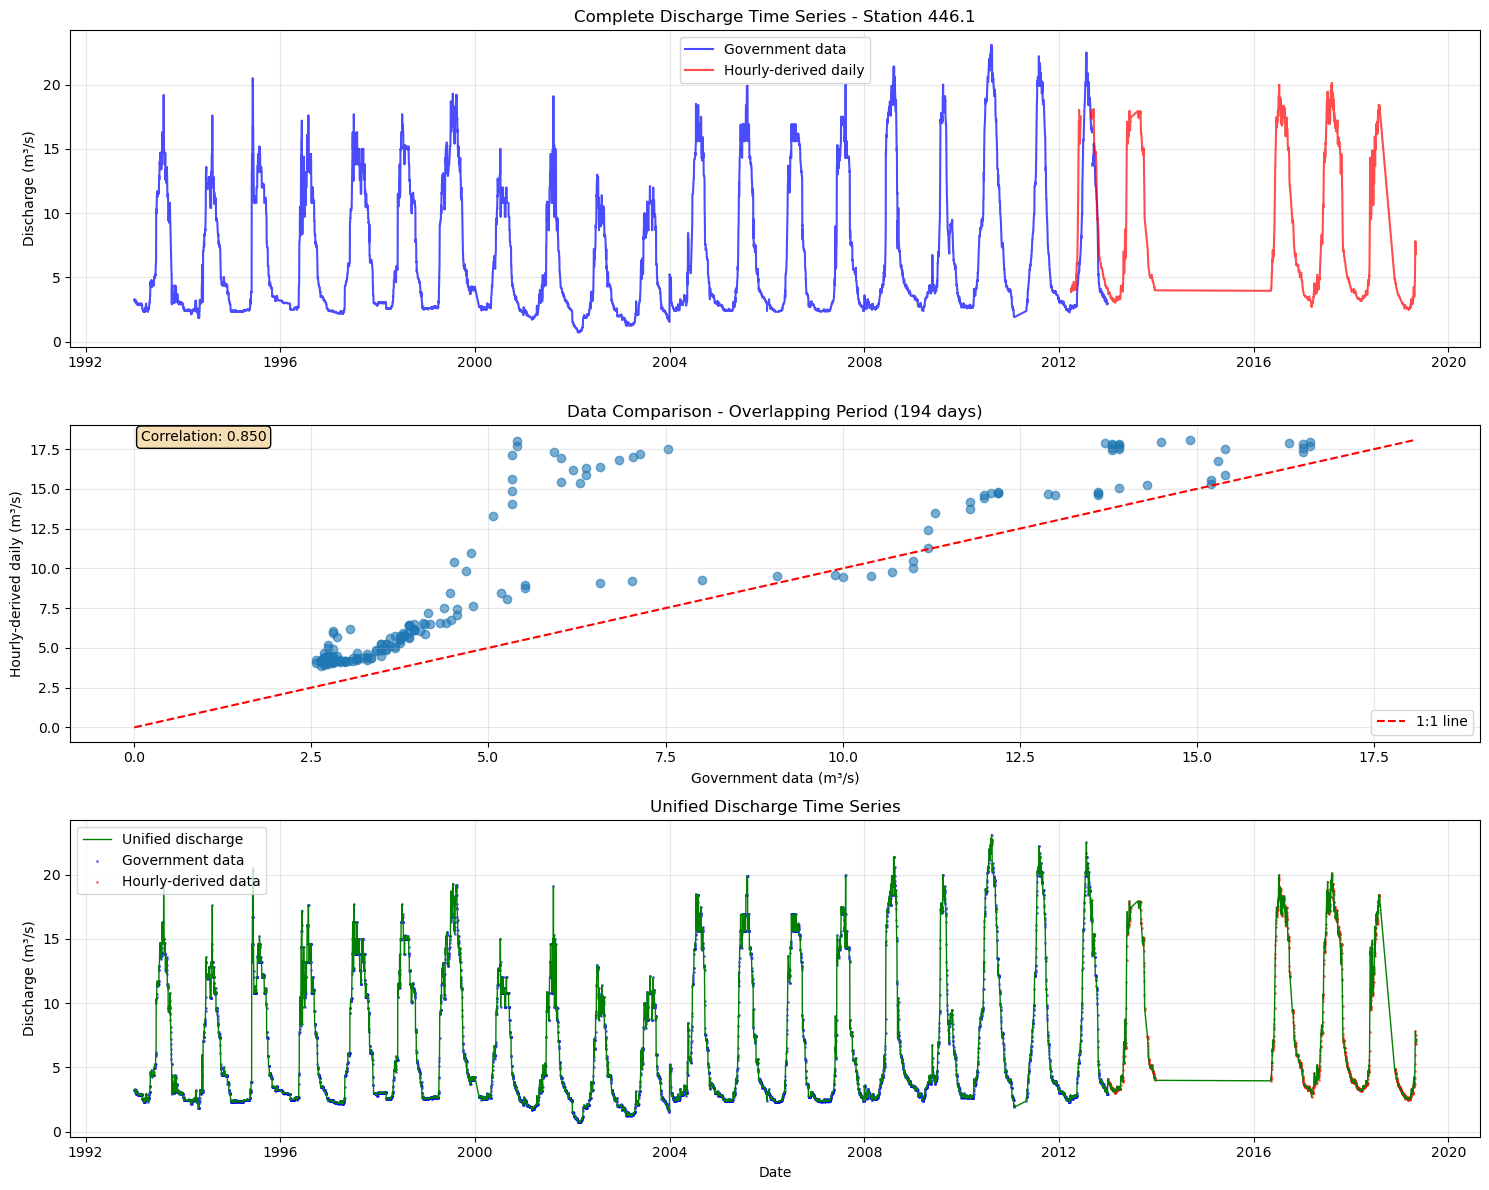


Data Summary Statistics:
Government data period: 1993-01-01 to 2012-12-31
Hourly data period: 2012-04-01 to 2019-05-03
Combined data period: 1993-01-01 to 2019-05-03
Total days with data: 8399


In [15]:
# Create visualizations to check data quality and overlap
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Plot 1: Full time series
axes[0].plot(combined_data['date'], combined_data['Q_govt'], 'b-', label='Government data', alpha=0.7)
axes[0].plot(combined_data['date'], combined_data['Q_mean'], 'r-', label='Hourly-derived daily', alpha=0.7)
axes[0].set_ylabel('Discharge (m³/s)')
axes[0].set_title('Complete Discharge Time Series - Station 446.1')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Overlapping period comparison (if any)
overlap_data = combined_data[(combined_data['Q_govt'].notna()) & (combined_data['Q_mean'].notna())]
if len(overlap_data) > 0:
    axes[1].scatter(overlap_data['Q_govt'], overlap_data['Q_mean'], alpha=0.6)
    axes[1].plot([0, overlap_data[['Q_govt', 'Q_mean']].max().max()], 
                 [0, overlap_data[['Q_govt', 'Q_mean']].max().max()], 'r--', label='1:1 line')
    axes[1].set_xlabel('Government data (m³/s)')
    axes[1].set_ylabel('Hourly-derived daily (m³/s)')
    axes[1].set_title(f'Data Comparison - Overlapping Period ({len(overlap_data)} days)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Calculate correlation if overlap exists
    correlation = overlap_data['Q_govt'].corr(overlap_data['Q_mean'])
    axes[1].text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
                transform=axes[1].transAxes, bbox=dict(boxstyle="round", facecolor='wheat'))
else:
    axes[1].text(0.5, 0.5, 'No overlapping data found', 
                transform=axes[1].transAxes, ha='center', va='center', fontsize=14)
    axes[1].set_title('Data Comparison - No Overlap')

# Plot 3: Unified time series
axes[2].plot(combined_data['date'], combined_data['Q_unified'], 'g-', label='Unified discharge', linewidth=1)
gov_mask = combined_data['Q_govt'].notna()
hourly_mask = combined_data['Q_mean'].notna() & combined_data['Q_govt'].isna()

axes[2].scatter(combined_data.loc[gov_mask, 'date'], combined_data.loc[gov_mask, 'Q_unified'], 
               c='blue', s=1, alpha=0.5, label='Government data')
axes[2].scatter(combined_data.loc[hourly_mask, 'date'], combined_data.loc[hourly_mask, 'Q_unified'], 
               c='red', s=1, alpha=0.5, label='Hourly-derived data')

axes[2].set_xlabel('Date')
axes[2].set_ylabel('Discharge (m³/s)')
axes[2].set_title('Unified Discharge Time Series')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nData Summary Statistics:")
print("=" * 50)
print(f"Government data period: {daily_govt['date'].min().strftime('%Y-%m-%d')} to {daily_govt['date'].max().strftime('%Y-%m-%d')}")
print(f"Hourly data period: {daily_from_hourly['date'].min().strftime('%Y-%m-%d')} to {daily_from_hourly['date'].max().strftime('%Y-%m-%d')}")
print(f"Combined data period: {combined_data['date'].min().strftime('%Y-%m-%d')} to {combined_data['date'].max().strftime('%Y-%m-%d')}")
print(f"Total days with data: {combined_data['Q_unified'].notna().sum()}")

In [8]:
# Save the combined dataset
output_file = "/home/jberg/OneDrive/Data_collection_Himalaya/streamflow/Nepal/other_streamflow_files/Combined_Daily_Discharge_Station446.1.csv"

# Prepare final dataset with clear column names
final_data = combined_data[['date', 'Q_govt', 'Q_mean', 'Q_min', 'Q_max', 'hourly_count', 'Q_unified', 'data_source']].copy()

# Rename columns for clarity
final_data.columns = [
    'Date',
    'Q_government_m3s',
    'Q_daily_mean_from_hourly_m3s', 
    'Q_daily_min_from_hourly_m3s',
    'Q_daily_max_from_hourly_m3s',
    'Hourly_data_count',
    'Q_unified_m3s',
    'Data_source'
]

# Add metadata
metadata = {
    'Station_ID': '446.1',
    'Station_name': 'Langtang Khola at Kyanjing',
    'Government_data_period': f"{daily_govt['date'].min().strftime('%Y-%m-%d')} to {daily_govt['date'].max().strftime('%Y-%m-%d')}",
    'Hourly_data_period': f"{daily_from_hourly['date'].min().strftime('%Y-%m-%d')} to {daily_from_hourly['date'].max().strftime('%Y-%m-%d')}",
    'Total_records': len(final_data),
    'Government_records': final_data['Q_government_m3s'].notna().sum(),
    'Hourly_derived_records': final_data['Q_daily_mean_from_hourly_m3s'].notna().sum(),
    'Processing_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

# Save the data
final_data.to_csv(output_file, index=False)

# Save metadata
metadata_file = output_file.replace('.csv', '_metadata.txt')
with open(metadata_file, 'w') as f:
    f.write("Combined Daily Discharge Data - Station 446.1\n")
    f.write("=" * 50 + "\n\n")
    for key, value in metadata.items():
        f.write(f"{key}: {value}\n")
    
    f.write(f"\nColumn Descriptions:\n")
    f.write("- Date: Date in YYYY-MM-DD format\n")
    f.write("- Q_government_m3s: Daily discharge from government station (1993-2012)\n")
    f.write("- Q_daily_mean_from_hourly_m3s: Daily mean discharge calculated from hourly data\n")
    f.write("- Q_daily_min_from_hourly_m3s: Daily minimum discharge from hourly data\n")
    f.write("- Q_daily_max_from_hourly_m3s: Daily maximum discharge from hourly data\n")
    f.write("- Hourly_data_count: Number of hourly measurements used for daily calculation\n")
    f.write("- Q_unified_m3s: Unified discharge (government data prioritized, filled with hourly-derived data)\n")
    f.write("- Data_source: Source of data (govt, hourly, or govt_hourly for overlapping dates)\n")

print(f"Combined dataset saved to: {output_file}")
print(f"Metadata saved to: {metadata_file}")
print(f"\nFinal dataset summary:")
print(f"Records: {len(final_data)}")
print(f"Date range: {final_data['Date'].min()} to {final_data['Date'].max()}")
print(f"Records with data: {final_data['Q_unified_m3s'].notna().sum()}")

Combined dataset saved to: /home/jberg/OneDrive/Data_collection_Himalaya/streamflow/Nepal/other_streamflow_files/Combined_Daily_Discharge_Station446.1.csv
Metadata saved to: /home/jberg/OneDrive/Data_collection_Himalaya/streamflow/Nepal/other_streamflow_files/Combined_Daily_Discharge_Station446.1_metadata.txt

Final dataset summary:
Records: 8399
Date range: 1993-01-01 00:00:00 to 2019-05-03 00:00:00
Records with data: 8399


In [9]:
# Create DFL format file with combined data
def create_dfl_file(final_data, output_path, station_id):
    """Create a DFL format text file from the combined data"""
    
    # Filter out rows with no data
    data_with_values = final_data[final_data['Q_unified_m3s'].notna()].copy()
    
    if len(data_with_values) == 0:
        print("No data available to create DFL file")
        return
    
    # Convert Date column to datetime if it's not already
    data_with_values['Date'] = pd.to_datetime(data_with_values['Date'])
    
    # Get year range
    years = sorted(data_with_values['Date'].dt.year.unique())
    
    # Create the DFL format text file
    with open(output_path, 'w') as f:
        # Write header
        f.write(f"Daily Flow of Station: {station_id} in m3/s\n")
        
        # Write years list
        for year in years:
            f.write(f" {year} \n")
        
        # Write data in DD/MMM/YYYY,flow format
        for _, row in data_with_values.iterrows():
            date_formatted = row['Date'].strftime('%d/%b/%Y')
            flow_value = row['Q_unified_m3s']
            f.write(f"{date_formatted},{flow_value}\n")
    
    print(f"✅ DFL format file created: {output_path}")
    return output_path

# Create the DFL file
dfl_output_path = "/home/jberg/OneDrive/Data_collection_Himalaya/streamflow/Nepal/Nepal_daily_discharge/DFL_446.1.txt"
dfl_file = create_dfl_file(final_data, dfl_output_path, "446.1")

# Verify the DFL file was created and show some content
if dfl_file and os.path.exists(dfl_file):
    print(f"\nDFL file verification:")
    print(f"File size: {os.path.getsize(dfl_file)} bytes")
    
    # Show first 30 lines of the output
    print(f"\nFirst 30 lines of DFL file:")
    with open(dfl_file, 'r') as f:
        lines = f.readlines()[:30]
        for i, line in enumerate(lines, 1):
            print(f"{i:2d}: {line.strip()}")
    
    # Show some statistics
    data_lines = [line for line in open(dfl_file, 'r') if ',' in line and '/' in line]
    print(f"\nDFL file statistics:")
    print(f"Total data records: {len(data_lines)}")
    print(f"Date range in file: {data_lines[0].split(',')[0]} to {data_lines[-1].split(',')[0]}")

✅ DFL format file created: /home/jberg/OneDrive/Data_collection_Himalaya/streamflow/Nepal/Nepal_daily_discharge/DFL_446.1.txt

DFL file verification:
File size: 144082 bytes

First 30 lines of DFL file:
 1: Daily Flow of Station: 446.1 in m3/s
 2: 1993
 3: 1994
 4: 1995
 5: 1996
 6: 1997
 7: 1998
 8: 1999
 9: 2000
10: 2001
11: 2002
12: 2003
13: 2004
14: 2005
15: 2006
16: 2007
17: 2008
18: 2009
19: 2010
20: 2011
21: 2012
22: 2013
23: 2016
24: 2017
25: 2018
26: 2019
27: 01/Jan/1993,3.21
28: 02/Jan/1993,3.26
29: 03/Jan/1993,3.32
30: 04/Jan/1993,3.21

DFL file statistics:
Total data records: 8399
Date range in file: 01/Jan/1993 to 03/May/2019
